# Preprocessing Data

In [4]:
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

In [25]:
os.makedirs('./datasets', exist_ok=True)
audio_path = '/root/Datasets/Features/M003/audio'
items = []
for path in sorted(Path(audio_path).rglob('*.npy')):
    audio_file = str(path)
    video_file = str(audio_file[:-4].replace('audio', 'landmark'))
    if os.path.exists(audio_file) and os.path.exists(video_file):
        items.append(f'{audio_file}|{video_file}\n')
    else:
        print(audio_file)

training_data, testing_data = train_test_split(items, test_size=0.2, random_state=25)

with open('./datasets/training_data.txt', 'w') as f:
    for item in training_data:
        f.write(item)
        
with open('./datasets/testing_data.txt', 'w') as f:
    for item in testing_data:
        f.write(item)

print(f'Training data size: {len(training_data)}')
print(f'Testing data size: {len(testing_data)}')

Training data size: 1600
Testing data size: 401


# Evaluation

In [5]:
import cv2
import numpy as np
from pathlib import Path
import json

gt_landmark_fpath = '/root/Datasets/Features/M003/landmark/front/neutral/level_1/001/'
gt_landmark_datas = [];
del_rows = []
for i in range(len(os.listdir(gt_landmark_fpath))):
    path = os.path.join(gt_landmark_fpath, f'{i}.json')
    with open(path) as json_file:
        data = json.load(json_file)
    if len(data['landmark']) == 68:
        gt_landmark_datas.append(np.asarray(data['landmark']).reshape(-1))
    else:
        del_rows.append(i)

gt_landmark_datas = np.asarray(gt_landmark_datas,dtype=np.int) # (Frame, 68*2)
gt_landmark_datas = np.expand_dims(gt_landmark_datas, axis=0)
print(gt_landmark_datas.shape)


pred_landmarks = np.load('./result/lm_pred.npy')
pred_landmarks = np.delete(pred_landmarks, del_rows, 0)
pred_landmarks = pred_landmarks.astype(int)
print(pred_landmarks.shape)

(1, 112, 136)
(1, 112, 136)


<ipython-input-5-e950bee3161d>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gt_landmark_datas = np.asarray(gt_landmark_datas,dtype=np.int) # (Frame, 68*2)


In [6]:
from common_eval import evaluate_normalized_mean_error_numpy

evaluate_normalized_mean_error_numpy(pred_landmarks, gt_landmark_datas)

0.08506098203832935

In [7]:
from common_eval import evaluate_normalized_mean_error
from logger import Logger

logger = Logger("result","logdir")
gt = gt_landmark_datas[0].reshape(gt_landmark_datas[0].shape[0], 68, 2)
pred = pred_landmarks[0].reshape(pred_landmarks[0].shape[0], 68, 2)
normalise_mean_error, accuracy_under_008, for_pck_curve = evaluate_normalized_mean_error(pred, gt,logger)

Compute NME and AUC for 112 images with 68 points :: [(NME): mean=8.506, std=1.627], auc@0.07=1.667, auc@0.08-5.739, acc@0.07=20.536, acc@0.08=42.857


# Visualize

In [8]:
from keypoint2img import *


pred_landmarks_exp = pred_landmarks[0]
pred_landmarks_exp = pred_landmarks_exp.reshape(pred_landmarks_exp.shape[0],68,2)
ones = np.ones((pred_landmarks_exp.shape[0],68,1), dtype=int)
pred_landmarks_exp = np.concatenate((pred_landmarks_exp,ones),axis=2)
print(pred_landmarks_exp.shape)

face_list, _, _, _, _, = define_edge_lists()

output = []
for face_pts in pred_landmarks_exp:
    output_edges = connect_keypoints(face_pts, face_list, (256,256))
    output.append(output_edges)
output = np.asarray(output)

(112, 68, 3)


In [9]:
output.shape

(112, 256, 256, 3)

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(output[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(output[0,:,:,:])

def animate(i):
    im.set_data(output[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=output.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

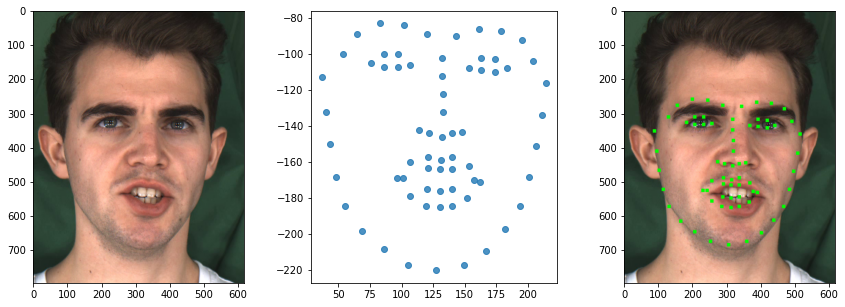

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('/root/Datasets/Features/M003/video_frames/front/neutral/level_1/001/0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.asarray(image)
landmarks = pred_landmarks[0][0].reshape(68,2)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)

ax = fig.add_subplot(1, 3, 3)
img2 = image.copy()

dsize = (256,256)
psize = 5
for k, p in enumerate(landmarks):
    relative_x = int(p[1] / dsize[0] * image.shape[0] )
    relative_y = int(p[0] / dsize[1] * image.shape[1] )
    img2[relative_x-psize:relative_x+psize, relative_y-psize:relative_y+psize, :] = (0, 255, 0)
ax.imshow(img2)
plt.show()